# Generative Networks for predicting Hollywood movie names
#### By Dattaraj J Rao ([dattarajrao@yahoo.com](mailto:dattarajrao@yahoo.com))
![](http://)### Author of "Keras to Kubernetes: The Journey of a Machine Learning Model to Production"
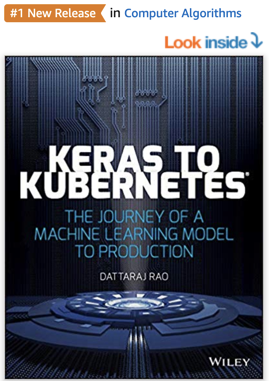


In [ ]:
# Author: Dattaraj Rao (dattarajrao@yahoo.com)
# Demonstration of generating new hollywood movie names by learning from move names datset
# More examples covered in book - Keras to Kubernetes: The Journey of a Machine Learning Model to Production
# https://www.amazon.com/Keras-Kubernetes-Journey-Learning-Production/dp/1119564832

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
# load the movie names and only isolate movie names
movies = pd.read_csv('../input/imdb-5000-movie-dataset/movie_metadata.csv')
print(movies.columns)
movie_titles = movies['movie_title']
movie_titles.head()

In [ ]:
# tokenize the corpus at word-level and build encodings
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
tok = Tokenizer()
tok.fit_on_texts(movie_titles)
vocab_size = len(tok.word_index) + 1
print("Vocabulary size = ", vocab_size)
print("-------------------------------")
# integer encode the documents
encoded_docs = tok.texts_to_sequences(movie_titles)
print("Encoded = ", encoded_docs[:10])
print("-------------------------------")
# pad documents to a max length of 10 words for movie title
max_length = 8
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='pre')
print("Padded = ", padded_docs[:10])
print("-------------------------------")

In [ ]:
# predict the next word as the result for training
from numpy import array
from keras.utils import to_categorical

# input is sequence and output next word
sequences = array(padded_docs)
print(sequences.shape)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [ ]:
# build recurrent network for training
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.utils.vis_utils import plot_model

# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
#model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# fit the model and show learning curves
history = model.fit(X, y, batch_size=128, epochs=100, validation_split=0.25)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# generate new data
from random import randint

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# select a seed text
for count in range(100):
    seed_text = movie_titles[randint(0,len(movie_titles))]
    print("Seed text = ", seed_text)

    # generate new text
    generated = generate_seq(model, tok, seq_length, seed_text, 5)
    print("Generated text = ", generated)